In [1]:
!pip install pytransit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.0/308.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 724.4/724.4 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 4.8 MB/s eta 0:00:00


# Overview
This notebook is my submission of the Sequential task i.e. third task for the project titled "Foundation Models for Exoplanet Characterization" by EXXA @ ML4SCI under GSoC'25

* Since training a classifier on just synthetic data will not be beneficial for inference on real data, I will use hybrid data creation
* For this strategy, I will use labelled data from Kepler mission Campaign 3
* Since this dataset is highly imbalanced with very positive labels, I will generate positive labels using following three strategies
    * Adding positive labels using pytransit
    * Over sampling using SMOTE
    * Augmenting flux in labelled data by following method
         - Circular time shift
         - Removing upper outliers since we look for dips
         - Adding moving average of the flux data

### All these points will be discussed in detail later in this notebook
      

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.random import normal, uniform
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, setp
from matplotlib import rc
import pandas as pd
from pytransit import TSModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.ndimage import uniform_filter1d
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Sampler, Dataset
from tqdm.auto import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

base_path = "./data/Kepler campaign 3/"
batch_size = 32
pi = np.pi
rc('figure', figsize=(13,5))

# Dataset Generation
Here I will define the dataset generation pipeline as well as custom dataset class

---
### ExoDataset: Custom PyTorch Dataset for Light Curves

The `ExoDataset` class is a PyTorch dataset designed for exoplanet detection using light curves. It provides key functionalities:

1. **Initialization**:  
   - Converts input `x_data` (light curves) and `y_data` (labels) into PyTorch tensors of type `float32`.  
   - Ensures compatibility with PyTorch models.

2. **Length Method (`__len__`)**:  
   - Returns the number of samples in the dataset.

3. **Item Retrieval (`__getitem__`)**:  
   - Retrieves a light curve sample \( x_i \) and its corresponding label \( y_i \).  
   - **Data Augmentation**: Applies a **random circular shift** along the time axis:  
     
     $x_i' = \text{roll}(x_i, \text{shift}=s)$
     
     where \( s \) is a random integer.

This augmentation helps the model learn translational invariance in time, making it robust to phase shifts in transit events.

---

### **Dataset Generation Pipeline for Exoplanet Detection using Light Curves**

This dataset generation pipeline is designed for detecting exoplanets via transit photometry. The pipeline incorporates various techniques to enhance data quality and improve model performance.

#### **1. Augmentations**
- A moving average filter is added as a separate channel to smooth out noise:
  
  $\tilde{x}_t = \frac{1}{N} \sum_{i=t-N}^{t} x_i$
  
  where \( N \) is the window size.

#### **2. Outlier Handling**
- Outliers (unusually high flux values) are replaced with the row mean:
  
  $x_{\max}, x_{\min} \to \mu_{\text{row}}$
  
  This ensures a cleaner dataset by reducing extreme values.

#### **3. SMOTE for Class Imbalance**
- **Synthetic Minority Over-sampling Technique (SMOTE)** is applied to balance classes:
  - Generates synthetic samples in the feature space.
  - Uses k-nearest neighbors to interpolate between minority class instances.

#### **4. Multi-planet Simulation**
- **PyTransit** supports single-planet simulations, but multi-planet systems are synthesized by:
  - Simulating transit curves for up to \( n \) planets independently.
  - Computing the final flux as:
    
    $F_{\text{final}} = \min(F_1, F_2, ..., F_n)$
    
    where \( $F_i$ \) represents the flux from each planet’s transit.
- Randomized planetary parameters such as semi-major axis (\( a \)), inclination (\( i \)), eccentricity (\( e \)), and transit depth (\( $\delta$ \)).

This pipeline effectively simulates realistic exoplanet transit data while handling noise, outliers, and class imbalance for robust exoplanet detection.

### **5. Pipeline Workflow**
- Load Exoplanet Light Curves (Real Data).

- Outlier Removal (Suppress spurious flux peaks).

- Generate Synthetic Transit Data (Single & Multi-planet Systems).

- Apply SMOTE for Class Balancing.

- Normalize & Standardize Data.

- Compute Moving Average Channel.

- One-hot Encode Labels.

- Shuffle & Finalize Dataset.

In [3]:
# Dataset class with circular time shift augmentation

class ExoDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)
        
    def __len__(self):
        return len(self.x_data)
        
    def __getitem__(self, idx):
        x_sample = self.x_data[idx]
        y_sample = self.y_data[idx]
        
        # Apply random circular shift in time (axis=0)
        shift = np.random.randint(0, x_sample.shape[0])
        x_sample = torch.roll(x_sample, shifts=shift, dims=0)
        
        return x_sample, y_sample



class DatasetCreator:
    def __init__(self, train_file = 'exoTrain.csv', test_file = 'exoTest.csv'):
        self.exoTrain = pd.read_csv(base_path + train_file)
        self.exoTest = pd.read_csv(base_path + test_file)
        self.time_steps = self.exoTrain.shape[1] - 1

    def handle_outliers(self, dataset, num_iterations):
        #threshold = None
        dataset_handled = dataset
    
        for n in range(num_iterations):
            #for column in range(dataset_handled.shape[0]):
            for index, row in dataset_handled.iterrows():
                row_values = row.values
                row_max, row_min = row_values.max(), row_values.min()
                row_maxidx, row_minidx = row_values.argmax(), row_values.argmin()
                row_mean = row_values.mean()
    
                #if np.abs(column_max/column_mean) >= threshold:
                dataset_handled.iloc[index][row_maxidx] = row_mean
    
                #if np.abs(column_min/column_mean) >= threshold:
                dataset_handled.iloc[index][row_minidx] = row_mean
    
        return dataset_handled

    def one_hot_encode(self, y_train, y_test):
        y_train_one_hot = np.zeros((y_train.shape[0], 2))
        y_test_one_hot = np.zeros((y_test.shape[0], 2))
        for i in range(y_train.shape[0]):
            y_train_one_hot[i, y_train[i]] = 1
        for i in range(y_test.shape[0]):
            y_test_one_hot[i, y_test[i]] = 1
        return y_train_one_hot, y_test_one_hot
    
    def smote(self, x_train, y_train):
        #smote = SMOTE(random_state=17, sampling_strategy='minority')
        over = SMOTE(sampling_strategy='minority')
        under = RandomUnderSampler(sampling_strategy='majority')
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        x_train_res, y_train_res = pipeline.fit_resample(x_train, y_train)
    
        return x_train_res, y_train_res

    def generate_transit_data(self, num_samples=500, 
                          max_planets=3, noise_level=1e-3, 
                          ld="power-2", time_steps = 300, npb=1, nldc = 2):
        pi = np.pi
        tm = TSModel(ld)
        
        t = np.linspace(0, 2, time_steps)
        tm.set_data(t, exptimes=0.02)
        npv = num_samples
        npp = max_planets
        ks =  np.linspace(-0.003, 0.003, npb)[np.newaxis, :] + normal(0.2, 0.01, (npv, npb, npp))
        t0s  = normal(0, 0.01, (npv, npp))
        ps    = uniform(0.5, 1.0, size=(npv, npp))
        smas  = normal(5.2, 0.1, (npv, npp))
        incs  = uniform(0.48*pi, 0.5*pi, (npv, npp))
        es    = uniform(0, 0.25, size=(npv, npp))
        os    = uniform(0, 2*pi, size=(npv, npp))
        ldp = np.tile(np.linspace(0.12, 1.2, nldc), (npp, npv, npb, 1))
        all_planet_flux = np.zeros((npp, npv, npb, time_steps))
        for i in range(npp):
            flux = tm.evaluate(ks[:, :, i], 
                               ldp[i, :, :, :], t0s[:, i], ps[:, i], 
                               smas[:, i], incs[:, i], es[:, i], os[:, i])
            
            all_planet_flux[i, :, :, :] = flux
        final_data = np.zeros((npv, npb, time_steps))
        label = []
        #random no. of planets in each system
        for i in range(npv):
            n = np.random.randint(1, npp+1)  # atleast 1 planet
            label.append(1)
            #ith data point contains n planets
            fluxi = np.ones((npb, time_steps))
            for j in range(n):
                fluxi = np.minimum(fluxi, all_planet_flux[j, i, :, :])
            final_data[i, :, :] = fluxi
            
        final_data += np.random.normal(0, noise_level, final_data.shape) # [npv, npb, time_steps]
        if (npb==1):
            final_data = final_data.squeeze(1)
        
        return final_data, np.array(label)

    def prepare_datasets(self, n_synthetic=2000, avg_over=200):
        self.x_train = self.exoTrain.iloc[:, 1:]
        self.y_train = self.exoTrain.iloc[:, 0].to_numpy() - 1
        self.x_test = self.exoTest.iloc[:, 1:].to_numpy()
        self.y_test = self.exoTest.iloc[:, 0].to_numpy() - 1

        # remove upper outliers in data since we are looking for dips in curve

        self.x_train = self.handle_outliers(self.x_train, 2)
        self.x_train = self.x_train.to_numpy()

        # add synthetic data generated from pytransit
        print("Preparing PyTransit Synthetic data...")
        x_syn, y_syn = self.generate_transit_data(num_samples = n_synthetic, 
                                         time_steps = self.time_steps)

        self.x_train = np.concatenate([self.x_train, x_syn], axis=0)
        self.y_train = np.concatenate([self.y_train, y_syn], axis=0)
        

        # add smote data
        print("Preparing SMOTE Synthetic data...")
        self.x_train, self.y_train = self.smote(self.x_train, self.y_train)

        # shuffle the dataset
        self.x_train, self.y_train = shuffle(self.x_train, self.y_train)

        #normalize
        self.x_train = ((self.x_train - np.mean(self.x_train, axis=1).reshape(-1,1)) / 
                   np.std(self.x_train, axis=1).reshape(-1,1))
        self.x_test = ((self.x_test - np.mean(self.x_test, axis=1).reshape(-1,1)) / 
                  np.std(self.x_test, axis=1).reshape(-1,1))

        # add moving average across time
        self.x_train = np.stack([self.x_train, uniform_filter1d(self.x_train, axis=1, size=avg_over)], axis=2)
        self.x_test = np.stack([self.x_test, uniform_filter1d(self.x_test, axis=1, size=avg_over)], axis=2)
        
        
        self.y_train, self.y_test = self.one_hot_encode(self.y_train, self.y_test)
        print('DONE!!')
        return self.x_train, self.y_train, self.x_test, self.y_test, x_syn
        

# **1D CNN Classifier and Utility functions**

## **Overview**
This model is a **1D Convolutional Neural Network (CNN)** designed to classify exoplanetary transit light curves. It processes sequential light curve data to detect transit signatures indicative of exoplanets.

## **Model Architecture**
The **Conv1DModel** is a deep convolutional network consisting of:
- **Four 1D Convolutional layers** with ReLU activations and **kernel size of 11**.
- **Batch Normalization** layers to stabilize training.
- **Max Pooling layers** (kernel size = 4, stride = 4) to reduce sequence length.
- **Fully connected layers** for classification.
- **Dropout layers** (0.5 and 0.25) to prevent overfitting.
- **Final output layer** with two neurons for binary classification (exoplanet present or not).

### **Workflow**
1. **Preprocessing**: Input light curves are structured as **(batch_size, sequence_length, channels)**.
2. **Feature Extraction**: The model applies **Conv1D** filters to extract transit features.
3. **Dimensionality Reduction**: **Max Pooling** reduces sequence length, keeping essential features.
4. **Flattening**: The output is flattened before entering the fully connected layers.
5. **Classification**: The final output predicts the presence/absence of an exoplanet.

## **Training and Optimization**
- **Loss Function**: Cross-Entropy Loss  
  
  $\mathcal{L} = - \sum_{i=1}^{N} y_i \log(\hat{y_i})$
  
  where \( $y_i$ \) is the true label and \( $\hat{y_i}$ \) is the predicted probability.
  
- **Optimizers**: Supports **Adam, SGD, RMSprop**, and others.
- **Learning Rate Schedulers**: Includes **ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau**.


In [4]:
class Conv1DModel(nn.Module):
    def __init__(self, input_shape=(3197, 2)):
        super(Conv1DModel, self).__init__()
        
        # For Conv1d, the input is expected to be (batch_size, channels, sequence_length)
        # So input_shape[1] = number of channels (2), input_shape[0] = sequence length (3197)
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=8, kernel_size=11, padding=5)
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.bn1 = nn.BatchNorm1d(8)
        
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=11, padding=5)
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.bn2 = nn.BatchNorm1d(16)
        
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=11, padding=5)
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=11, padding=5)
        self.pool4 = nn.MaxPool1d(kernel_size=4, stride=4)
        
        # Calculate the size after all conv/pool layers
        # After 4 pooling layers with stride 4, the sequence length reduces by factor of 4^4 = 256
        feature_size = input_shape[0] // 256
        if feature_size == 0:  # Handle case where input is too small
            feature_size = 1
        self._to_linear = 64 * feature_size  # 64 channels after last conv layer
        
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(self._to_linear, 64)
        
        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(64, 64)
        
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        # Input x has shape (batch_size, seq_len, channels)
        # Conv1d expects (batch_size, channels, seq_len)
        #print(x.shape)
        x = x.permute(0, 2, 1)
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.bn1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.bn3(x)
        
        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        
        x = self.fc3(x)
        return x

def train_fn(model, train_loader, optimizer, criterion, device):
    model.to(device).train()
    it_loss = 0
    counter = 0

    for batch_x, batch_y in tqdm(train_loader):
        #print(batch_x.shape)
        batch_x = batch_x.to(device)  # Move batch_x to device
        batch_y = batch_y.to(device)  # Move batch_y to device

        optimizer.zero_grad()
        out = model(batch_x)
        loss = criterion(out, batch_y)  # Ensure correct shape for loss computation
        loss.backward()
        optimizer.step()

        it_loss += loss.item() * batch_x.shape[0]
        counter += batch_x.shape[0]

    return it_loss / counter  # Return average loss

def test_fn(model, test_loader, device, criterion):
    model.to(device).eval()
    it_loss = 0
    counter = 0
    for batch_x, batch_y in tqdm(test_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        with torch.no_grad():
            out = model(batch_x)
            loss = criterion(out, batch_y)
            it_loss += loss.item() * batch_x.shape[0]
            counter += batch_x.shape[0]
    return it_loss/counter

def run_epochs(model, train_loader, val_loader, save_dir, 
               epochs=40, lr=1e-4, optimizer='adam', scheduler='ExponentialLR', 
               weight_decay=0.01, criterion='CrossEntropyLoss'):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if (optimizer == 'adam'):
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif (optimizer == 'adamw'):
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif (optimizer == 'radam'):
        optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay = weight_decay)
    elif (optimizer == 'sgd'):
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay = weight_decay)
    elif (optimizer == 'rmsprop'):
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay = weight_decay)
    else:
        print("Unknown optimzer, pass optimizer object instead for this")
        return 

    
    if (scheduler.lower() == 'reducelronplateau'):
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
    elif (scheduler.lower() == 'cosineannealinglr'):
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)
    elif (scheduler.lower() == 'exponentiallr'):
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94)
    else:
        print("Unknown scheduler, pass scheduler object instead for this")
        return 

    if (criterion.lower() == 'crossentropyloss'):
        criterion = nn.CrossEntropyLoss()
    elif (criterion.lower() == 'bcewithlogitsloss'):
        criterion = nn.BCEWithLogitsLoss()
    elif (criterion.lower() == 'bceloss'):
        criterion = nn.BCELoss()
    else:
        print("Unknown loss function, pass scheduler object instead for this")
        return 

    best_loss = float('inf')
    for epoch in range(epochs):
        train_loss = train_fn(model, train_loader, optimizer, criterion, device)
        val_loss = test_fn(model, val_loader, device, criterion)
        if (scheduler is not None):
            scheduler.step(val_loss)

        if (train_loss < best_loss):
            best_loss = train_loss
            torch.save({
                'model_dict':model.state_dict(),
                'optimizer_dict':optimizer.state_dict()
            }, save_dir)

            print('MODEL SAVED!')
        print(f'Epoch {epoch+1}, Train loss: {train_loss:.6f}, Val Loss : {val_loss:.6f}')
    return best_loss, save_dir

# Initializing dataset
* Final dataset will be balanced
* Considers light curves for multi planet systems as well

### Note : Test data is not oversampled by any means

In [5]:
obj = DatasetCreator()
x_train, y_train, x_test, y_test, x_syn = obj.prepare_datasets()
inp_shape = (x_train.shape[1], x_train.shape[2])
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                  test_size=0.2, random_state=42)

train_dataset = ExoDataset(x_train, y_train)
val_dataset = ExoDataset(x_val, y_val)
test_dataset = ExoDataset(x_test, y_test)

sampler = BalancedBatchSampler(y_train, batch_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

Preparing PyTransit Synthetic data...
Preparing SMOTE Synthetic data...
DONE!!


### Lets visualize some samples

In [6]:
pos_indices = np.where(y_train[:, 1] == 1)[0].tolist()
neg_indices = np.where(y_train[:, 0] == 1)[0].tolist()

random_pos_inds = random.sample(pos_indices, 10)
random_neg_inds = random.sample(neg_indices, 10)

def plot_single_lc(time, flux, c=None, ax=None):
    ylim = (flux.min(), flux.max())
    if ax is None:
        fig, ax = subplots()
    else:
        fig, ax = None, ax
    ax.plot(time, flux, c=c)
    ax.autoscale(axis='x', tight=True)
    setp(ax, xlabel='Time [d]', ylabel='Flux', xlim=time[[0,-1]], ylim=ylim)
    
    if fig is not None:
        fig.tight_layout()
    return ax

def plot_sample_lcs(indices):
    for ind in indices:
        f = x_train[ind, :, 0].T
        t = np.linspace(0, 2, f.shape[0])
        _ = plot_single_lc(t, f, c='0.5')

### Plotting negative samples

Plottg negative samples


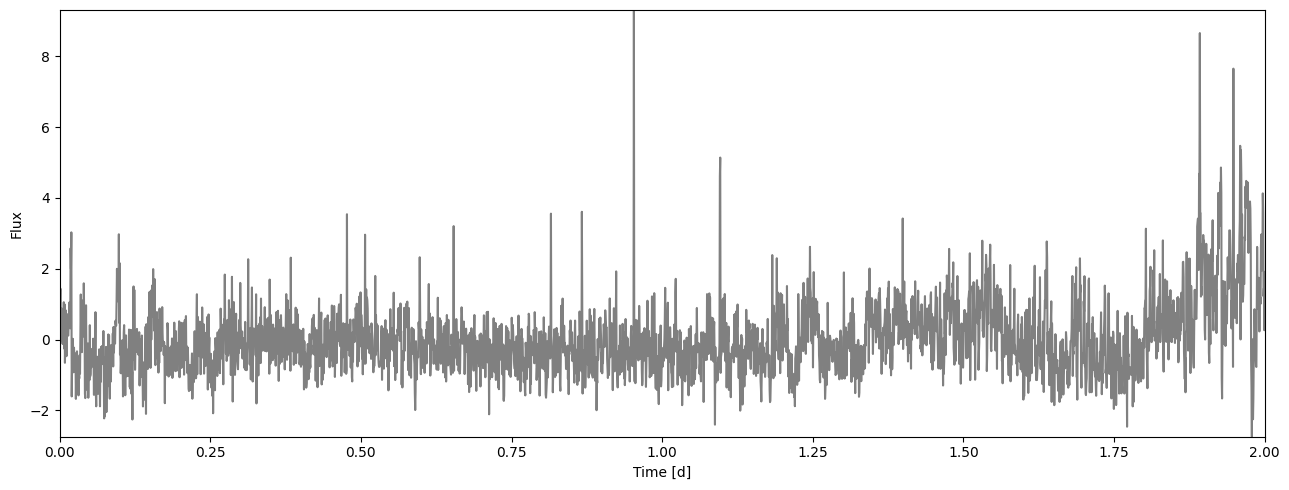

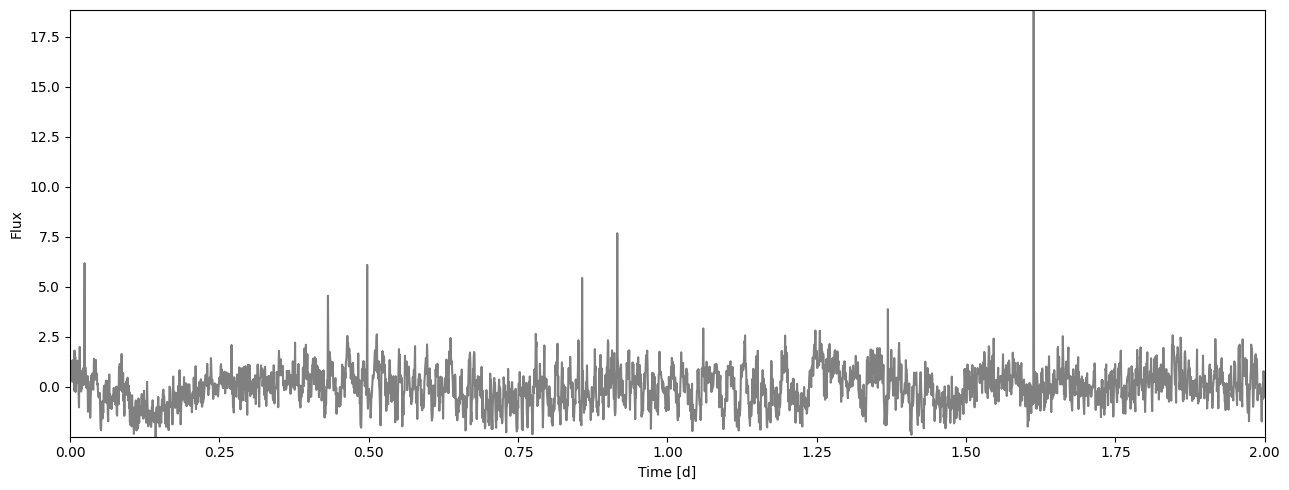

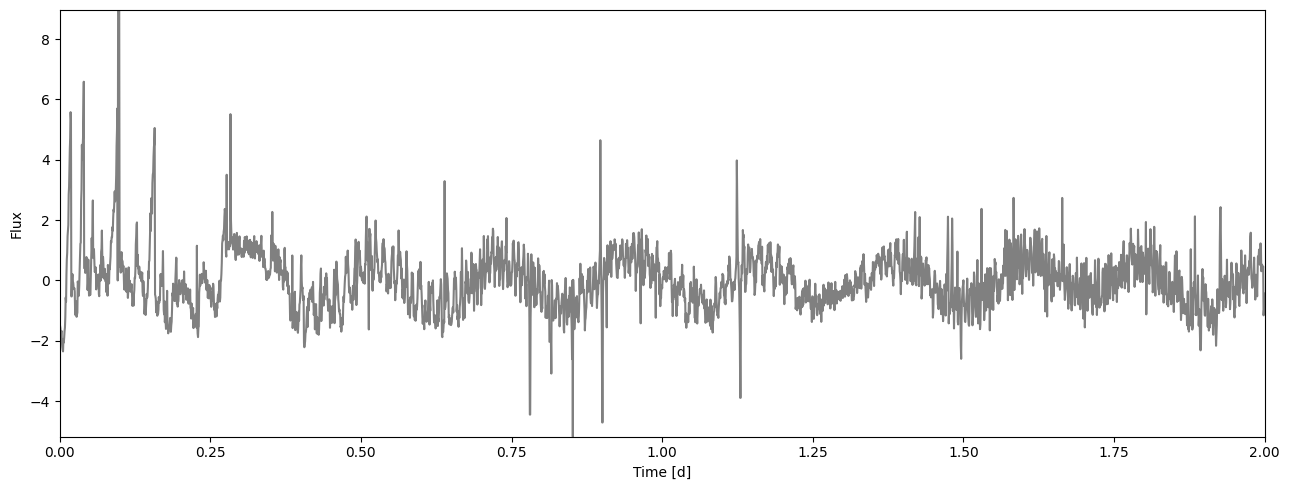

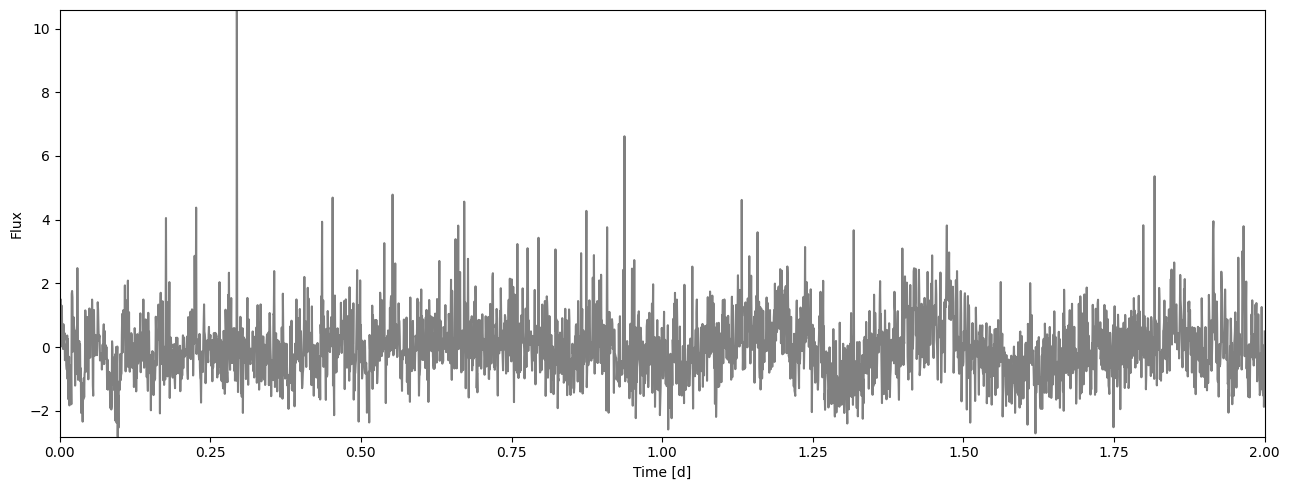

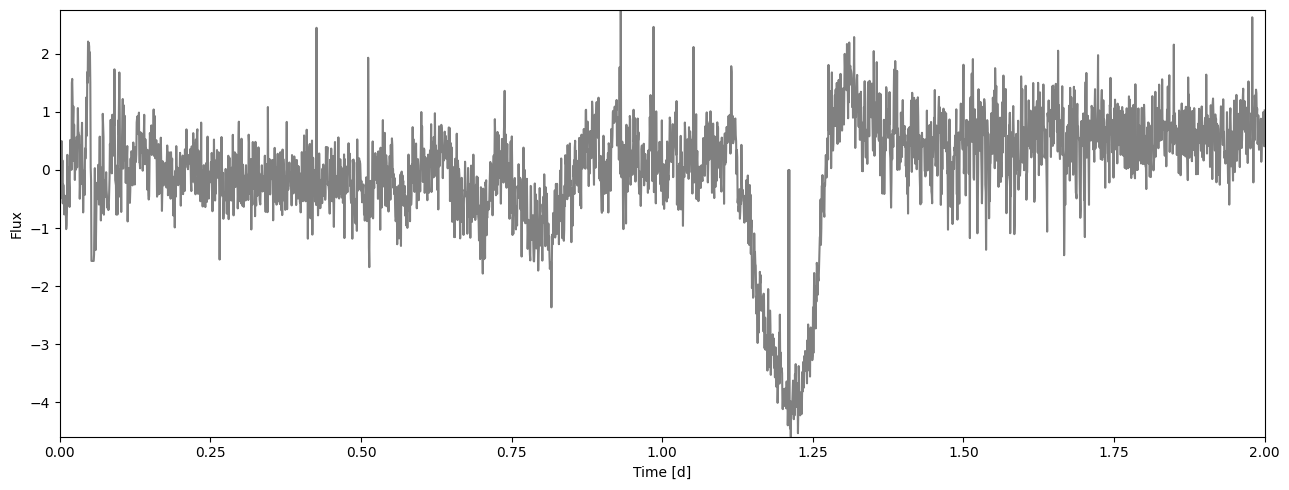

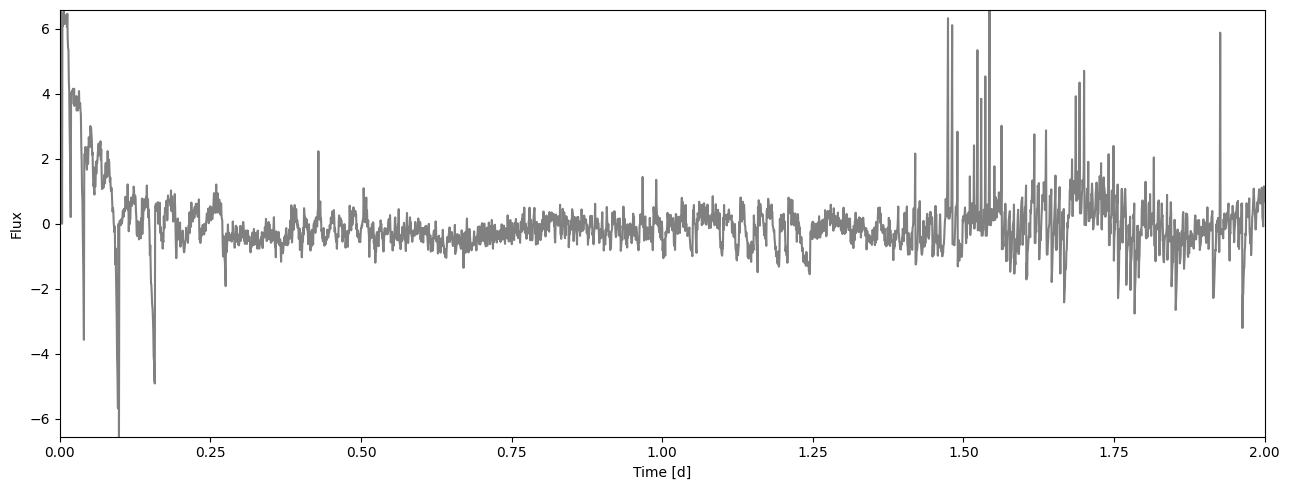

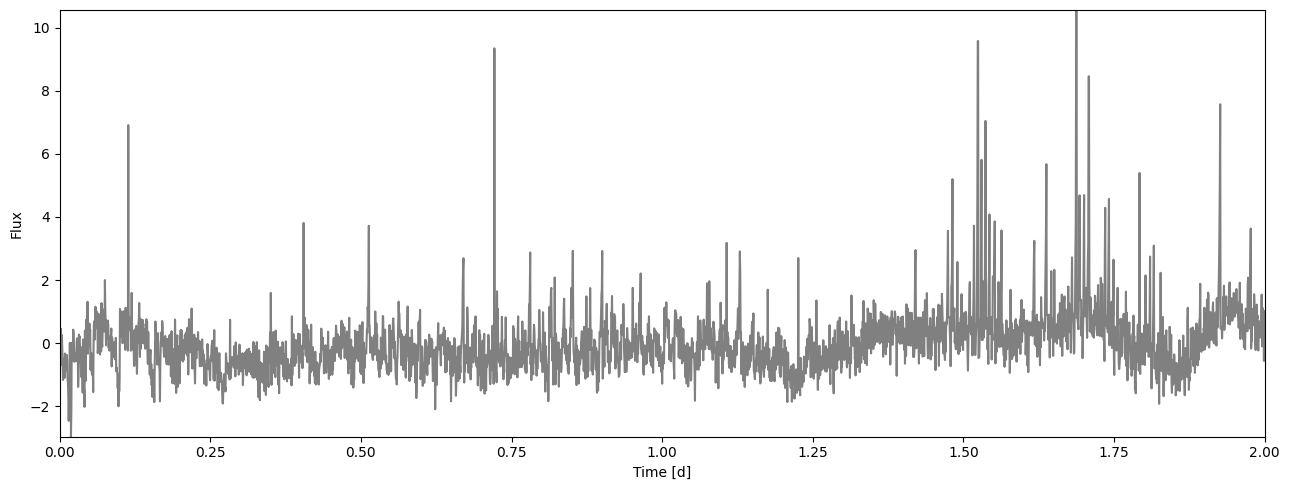

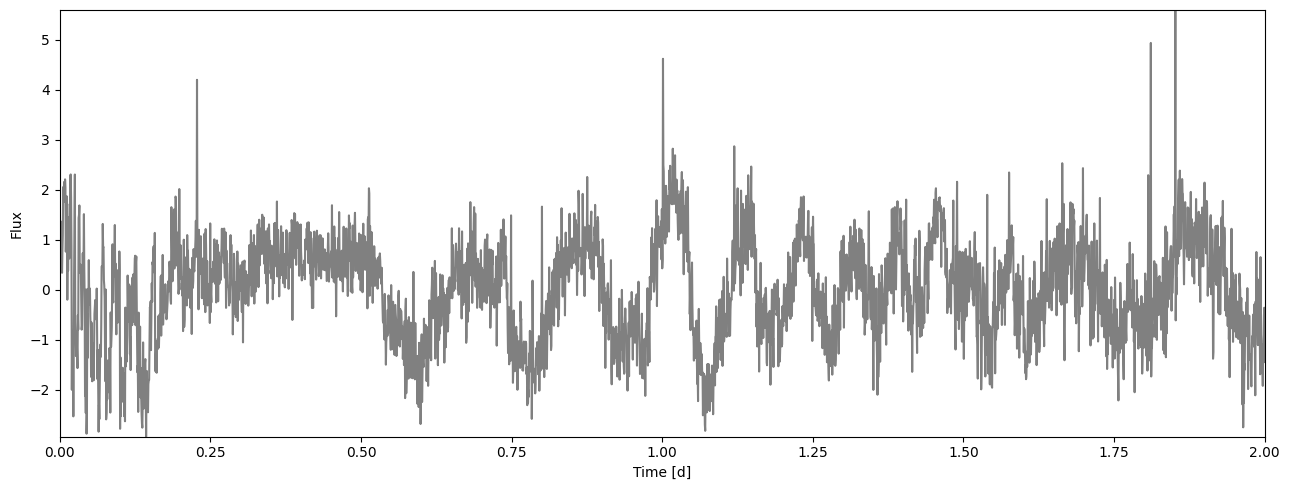

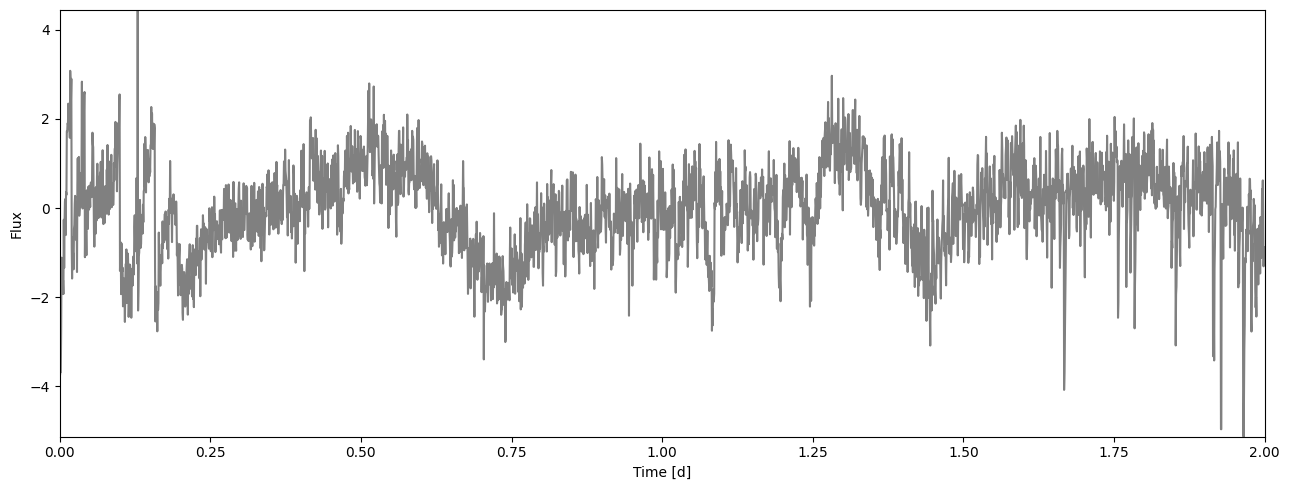

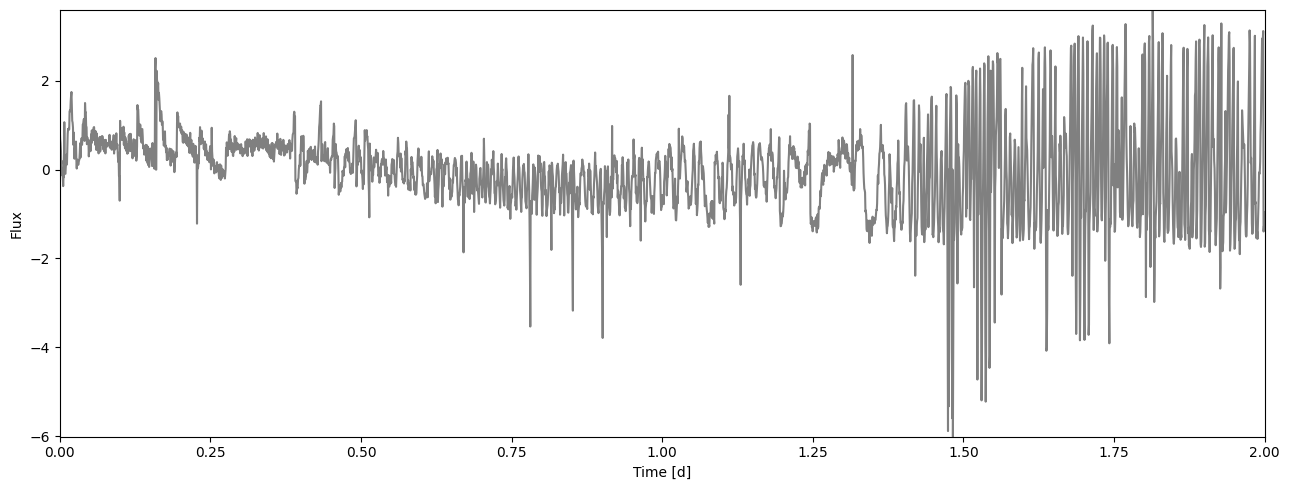

In [7]:
print('Plottg negative samples')
plot_sample_lcs(random_neg_inds)

### Plotting positive samples

Plottg positive samples


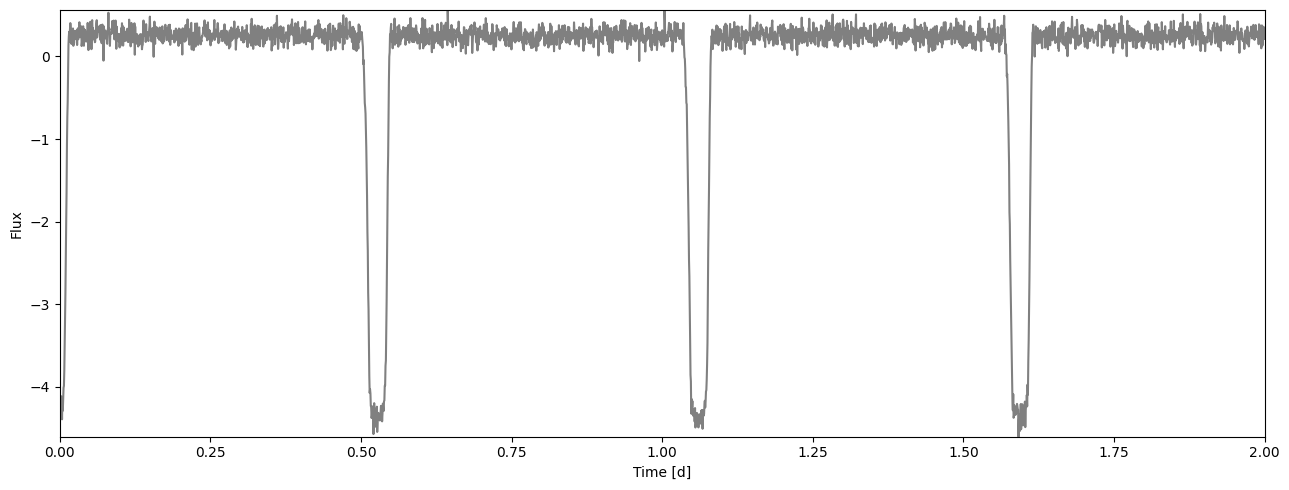

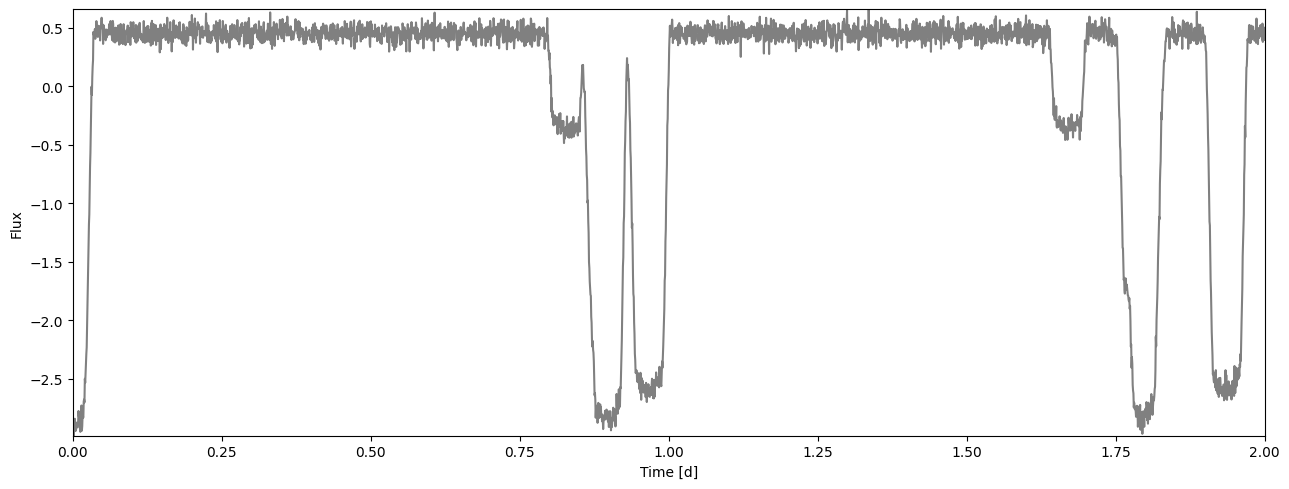

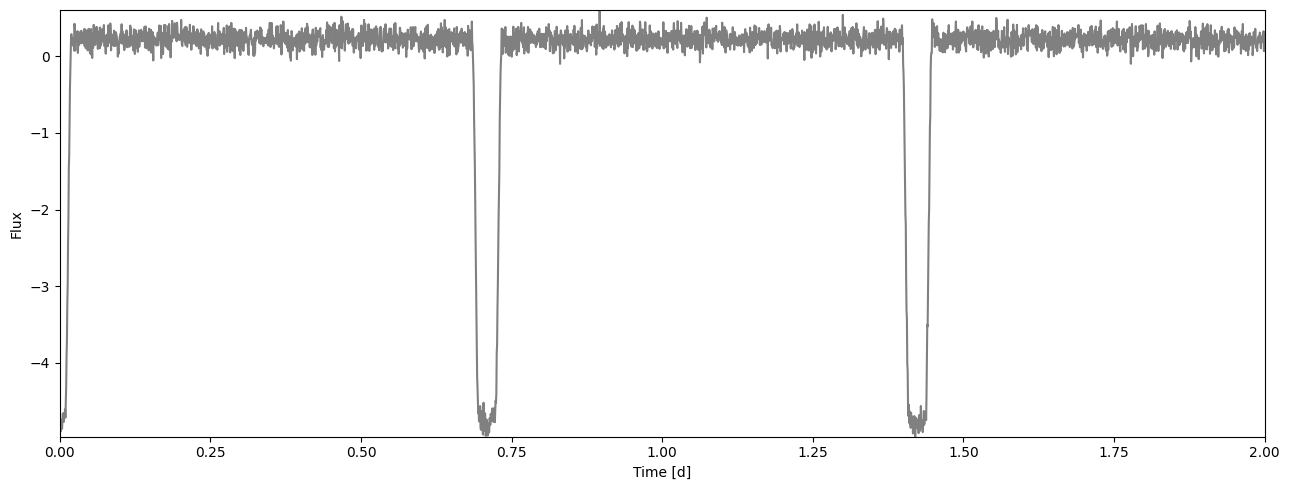

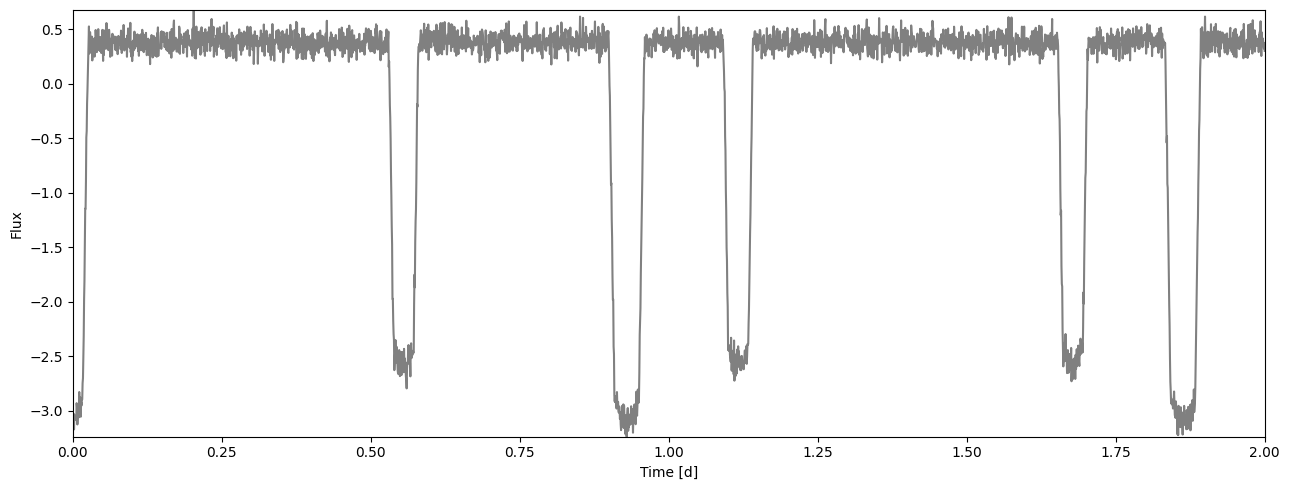

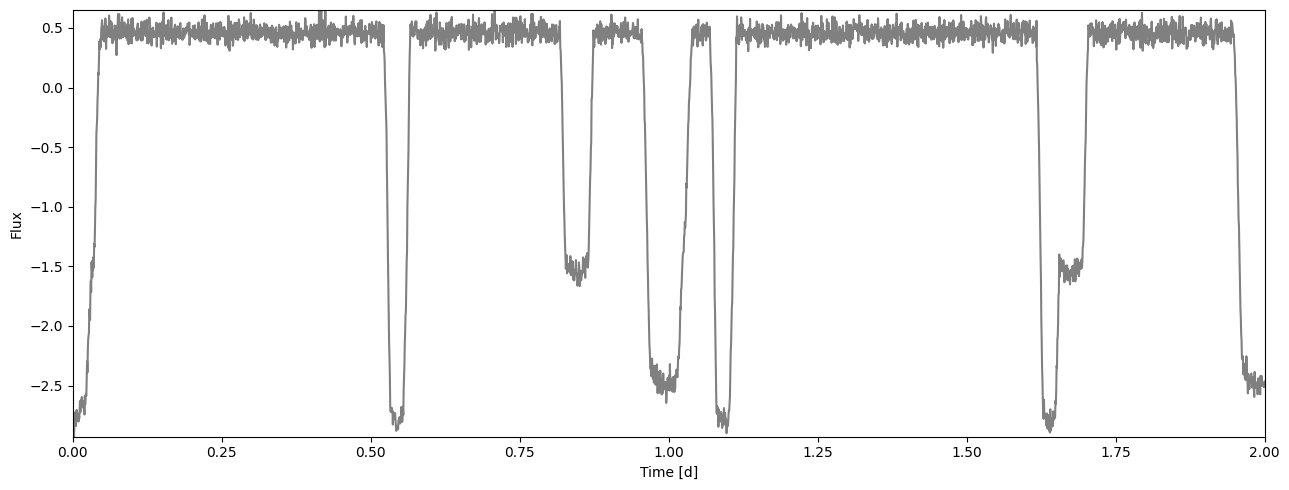

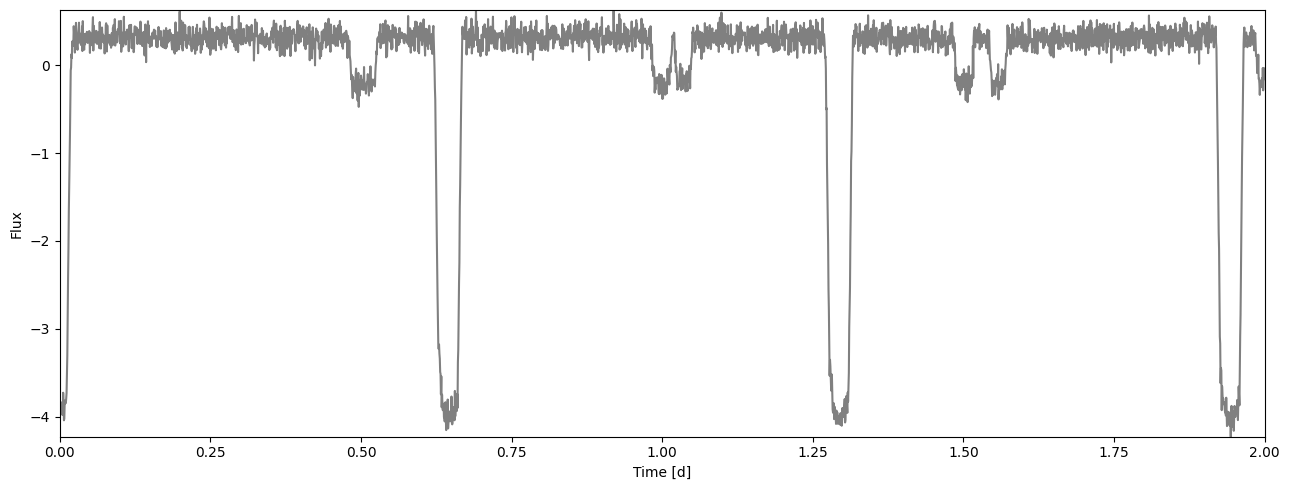

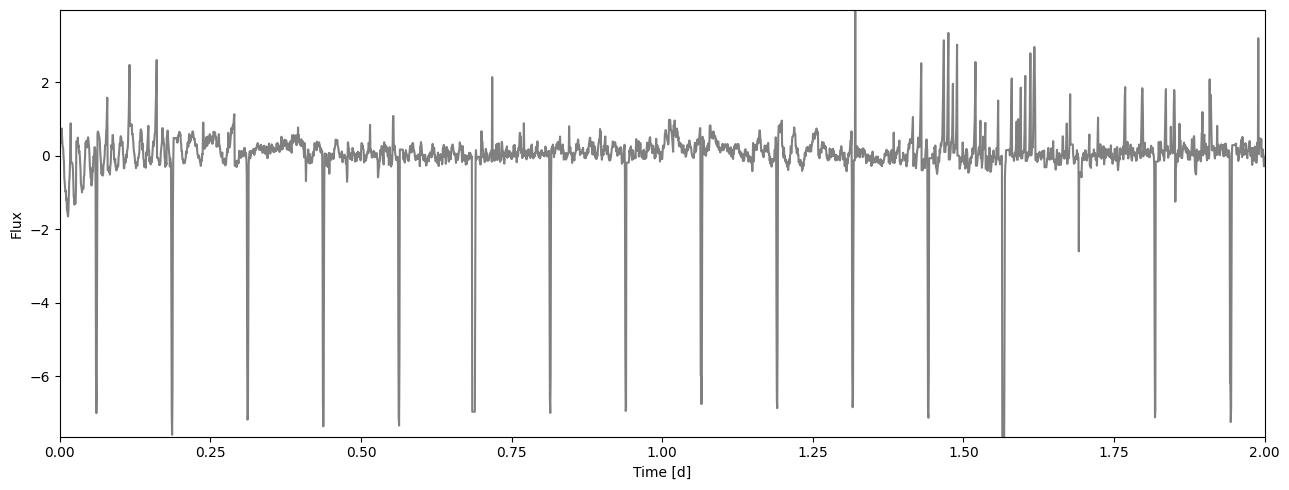

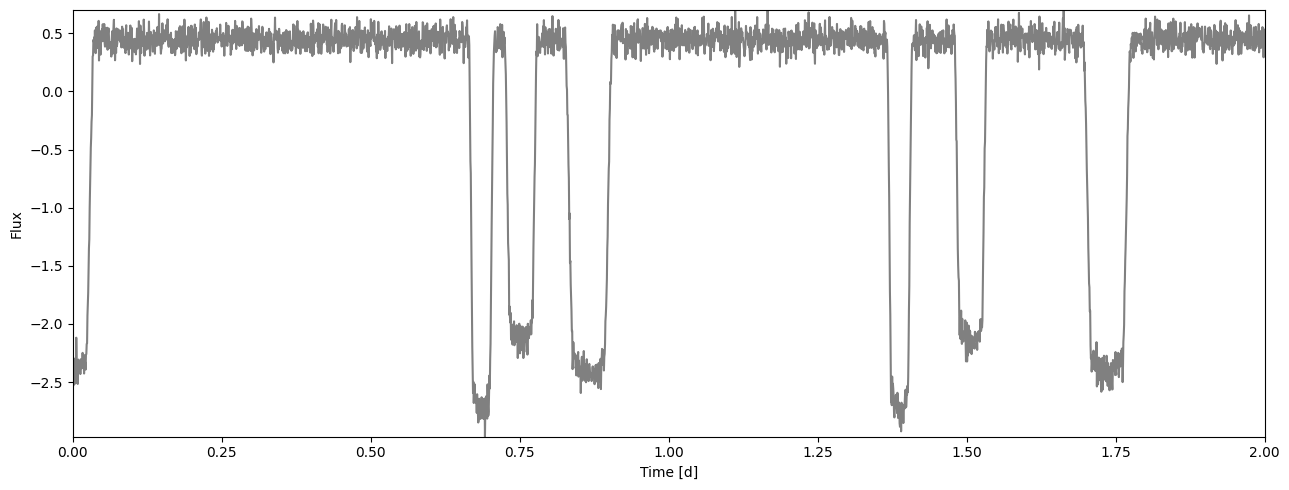

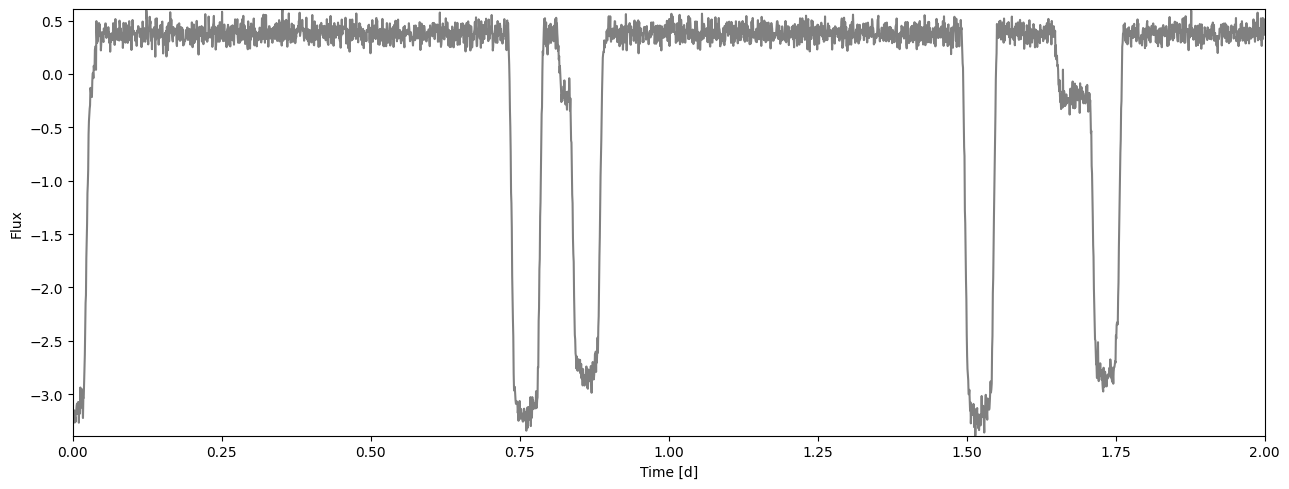

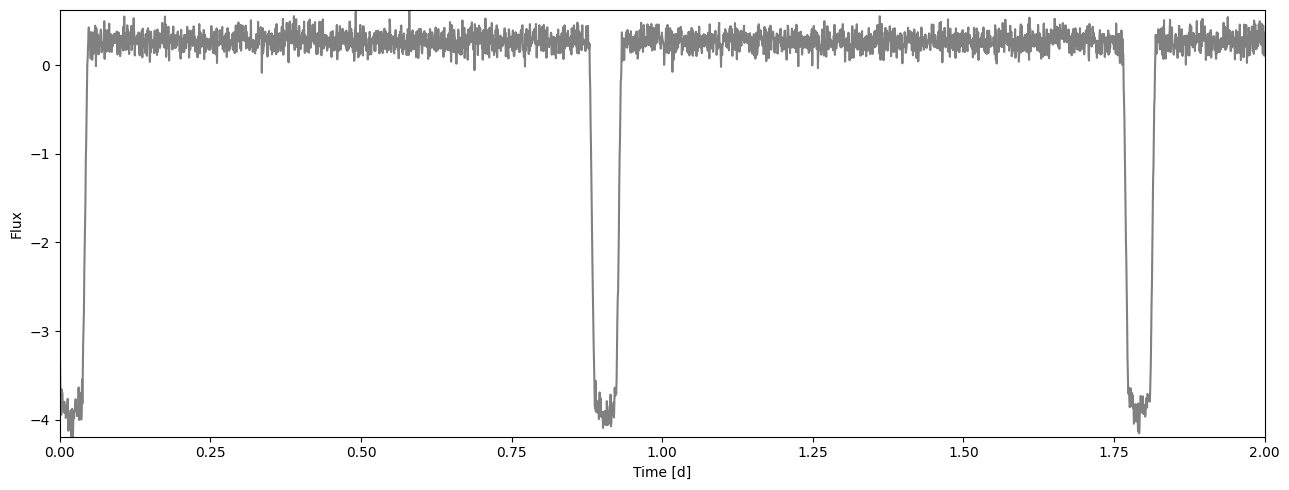

In [8]:
print('Plottg positive samples')
plot_sample_lcs(random_pos_inds)

# Training
Training the model and saving the weights

### Hyperparameters:
- epochs $= 40$
- optimizer used is `Adam`
- scheduler is `ExponentialLR` with $\gamma = 0.94$
- L2 Regularization is used with weight decay $0.01$
- learning rate $\alpha = 10^{-4}$
- loss function : `nn.CrossEntropyLoss()`

In [9]:
model = Conv1DModel(inp_shape)
save_dir = "./models/CNN1d_classifier.pth"

best_loss, _ = run_epochs(model, train_loader, val_loader, save_dir, 
               epochs=40, lr=1e-4, optimizer='adam', scheduler='ExponentialLR', 
               weight_decay=0.01, criterion='CrossEntropyLoss')
print(f"BEST cross-entropy loss : {best_loss}")

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 1, Train loss: 0.169886, Val Loss : 0.047835


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 2, Train loss: 0.047564, Val Loss : 0.042361


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 3, Train loss: 0.042929, Val Loss : 0.038310


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 4, Train loss: 0.041540, Val Loss : 0.037658


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 5, Train loss: 0.040034, Val Loss : 0.035594


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 6, Train loss: 0.041567, Val Loss : 0.035766


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 7, Train loss: 0.041237, Val Loss : 0.036094


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 8, Train loss: 0.037839, Val Loss : 0.036915


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 9, Train loss: 0.038482, Val Loss : 0.033631


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 10, Train loss: 0.037877, Val Loss : 0.032530


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 11, Train loss: 0.035031, Val Loss : 0.031564


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 12, Train loss: 0.036777, Val Loss : 0.032603


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 13, Train loss: 0.033135, Val Loss : 0.029025


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 14, Train loss: 0.032109, Val Loss : 0.027401


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 15, Train loss: 0.032390, Val Loss : 0.028595


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 16, Train loss: 0.029422, Val Loss : 0.026585


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 17, Train loss: 0.029485, Val Loss : 0.028501


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 18, Train loss: 0.027468, Val Loss : 0.025203


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 19, Train loss: 0.029908, Val Loss : 0.024977


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 20, Train loss: 0.027009, Val Loss : 0.021030


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 21, Train loss: 0.026273, Val Loss : 0.021336


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 22, Train loss: 0.024939, Val Loss : 0.021175


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 23, Train loss: 0.021550, Val Loss : 0.019077


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 24, Train loss: 0.023192, Val Loss : 0.020387


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25, Train loss: 0.023123, Val Loss : 0.020667


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 26, Train loss: 0.019090, Val Loss : 0.019209


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 27, Train loss: 0.020016, Val Loss : 0.022690


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 28, Train loss: 0.019871, Val Loss : 0.018871


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 29, Train loss: 0.020579, Val Loss : 0.018437


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 30, Train loss: 0.022692, Val Loss : 0.015999


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 31, Train loss: 0.019467, Val Loss : 0.018643


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 32, Train loss: 0.017405, Val Loss : 0.017933


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 33, Train loss: 0.018548, Val Loss : 0.020060


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 34, Train loss: 0.018901, Val Loss : 0.016260


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 35, Train loss: 0.017318, Val Loss : 0.017966


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 36, Train loss: 0.017014, Val Loss : 0.017892


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 37, Train loss: 0.017908, Val Loss : 0.019539


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 38, Train loss: 0.017114, Val Loss : 0.017681


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 39, Train loss: 0.017426, Val Loss : 0.017659


  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 40, Train loss: 0.016838, Val Loss : 0.016418
BEST cross-entropy loss : 0.01683809072894994


# Evaluating classifier using ROC AUC score

In [10]:
def evaluate_model(model, test_loader, device):
    
    model.to(device).eval()
    sf = nn.Softmax(dim=-1)
    preds=[]
    y_true=[]
    for batch_x, batch_y in tqdm(test_loader):
        batch_x = batch_x.to(device)
        y_true.append(batch_y.to('cpu').numpy())
        with torch.no_grad():
            out = model(batch_x)
            out = sf(out)
            preds.append(out.to('cpu').numpy())
    logits = np.concatenate(preds)
    preds = logits.argmax(-1)
    y_one_hot = np.concatenate(y_true)
    y_true = y_one_hot.argmax(-1)
    acc = accuracy_score(y_true, preds)
    roc = roc_auc_score(y_one_hot, logits)
    print(f'Accuracy : {acc*100:.6f}%\nROC AUC Score : {roc:.6f}')
    return logits, preds, y_one_hot, y_true

# Results
Below are the results on the real labelled Kepler mission Campaign 3 dataset

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
check_point = torch.load(save_dir)
model = Conv1DModel(input_shape=inp_shape).to(device)
model.load_state_dict(check_point['model_dict'])
temp = evaluate_model(model, test_loader, device)

  0%|          | 0/18 [00:00<?, ?it/s]

Accuracy : 98.947368%
ROC AUC Score : 0.993274


# Final ROC AUC Score = $0.993$